In [171]:
# Quantum
import pennylane as qml

# Numpy
import numpy as np

# Plot
import matplotlib.pyplot as plt

%matplotlib inline


---

### Lemma 1

In [172]:
class Lemma1:
    '''
        QAF 논문 Lemma 1을 구현하기 위한 class
    '''
    def __init__(self, w, x, b):
        '''
            w(list) : list for weight
            x(list) : list for x(input) 
            b(float) : float value of bias
        '''
        # list Initiallize
        self.w_list = w
        self.x_list = x
        self.b = b

        # vector Initiallize
        self.x = np.array(self.x_list)
        self.w = np.array(self.w_list)

        # lengths Calculate
        self.N_in = len(x)
        self.N = int(2 ** (np.ceil(np.log2(self.N_in + 3))))
        self.n = int(np.log2(self.N))

        # A_x, A_wb Calculate
        self.A_x  = np.sqrt(self.N_in - (self.x @ self.x))
        self.A_wb = np.sqrt(self.N_in + 1 - (self.w @ self.w + self.b * self.b))

        # v_x, v_wb
        self.v_x  = [self.A_x]  + self.x_list + [1.0]       + ([0.0] * (self.N - self.N_in - 2))
        self.v_wb = [0.0]       + self.w_list + [self.b]    + ([0.0] * (self.N - self.N_in - 3)) + [self.A_wb]

        # device initiallize
        # n : num_qubit
        self.dev = qml.device("default.qubit", wires=self.n)

    def norm(self, vec):
        return np.linalg.norm(vec)

    def u(self, vec):
        qml.AmplitudeEmbedding(vec, wires=range(self.n), normalize=True)

    def lemma1(self, chk=False):
        @qml.qnode(device=self.dev)
        def inner_lemma1():
            # U_x, i.e. small_u(v_x)
            self.u(self.v_x)

            # U_wb, i.e. small_u(v_wb)^†, Pauli-X for each qubit
            qml.adjoint(self.u)(self.v_wb)
            for i in range(self.n):
                qml.PauliX(wires=i)
            
            return qml.state()
        if chk:
            print(qml.draw_mpl(inner_lemma1)())
        return inner_lemma1()[-1]

(<Figure size 600x400 with 1 Axes>, <Axes: >)


tensor(0.058-1.86190061e-18j, requires_grad=True)

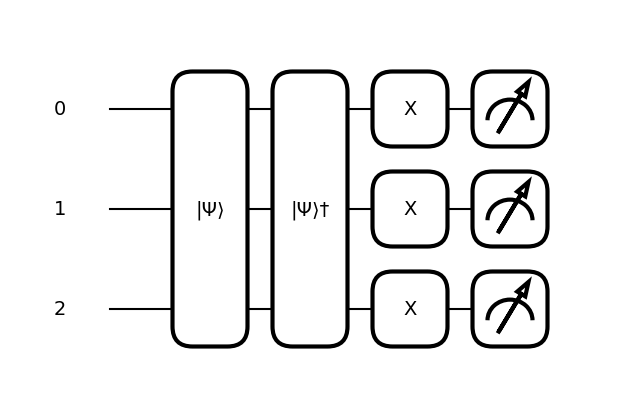

In [173]:
# list Initiallize
x_list = [0.1, -0.2, 0.3, -0.4]
w_list = [0.8, 0.7, -0.9, -0.3]
b = 0.5

test1 = Lemma1(w=w_list, x=x_list, b=b)
test1.lemma1(chk=True)

---

### Theorem 1, Corollary 1

In [ ]:
class Theorem1:
    '''
        QAF 논문 Theorem 1을 구현하기 위한 class
    '''
    def __init__(self, w, x, b, d):
        '''
            w(list)     : list for weight
            x(list)     : list for x(input) 
            b(float)    : float value of bias
            d(int)      : degree for Taylor (polynomial) Expansion
        '''
        # list Initiallize
        self.w_list = w
        self.x_list = x
        self.b = b
        self.d = d

        # vector Initiallize
        self.x = np.array(self.x_list)
        self.w = np.array(self.w_list)

        # lengths Calculate
        self.N_in = len(x)
        self.N = int(2 ** (np.ceil(np.log2(self.N_in + 3))))
        self.n = int(np.log2(self.N))

        # A_x, A_wb Calculate
        self.A_x  = np.sqrt(self.N_in - (self.x @ self.x))
        self.A_wb = np.sqrt(self.N_in + 1 - (self.w @ self.w + self.b * self.b))

        # v_x, v_wb
        self.v_x  = [self.A_x]  + self.x_list + [1.0]       + ([0.0] * (self.N - self.N_in - 2))
        self.v_wb = [0.0]       + self.w_list + [self.b]    + ([0.0] * (self.N - self.N_in - 3)) + [self.A_wb]

        # test z = wx + b
        # z = (self.w @ self.x + self.b) / (self.N_in + 1)
        # print(z)


        # device initiallize
        # n : num_qubit
        self.dev = qml.device("default.qubit", wires=(self.n + self.d))

    def U_z(self):
        qml.AmplitudeEmbedding(self.v_x, wires=range(self.n), normalize=True)
        qml.adjoint(qml.AmplitudeEmbedding)(self.v_wb, wires=range(self.n), normalize=True)
        for i in range(self.n):
            qml.PauliX(wires=i)

    def V(self, m):
        a_m = self.n + m

        # Controlled-Hadamard for (control, target) : (q register, a_m)
        qml.ctrl(qml.Hadamard, control=range(self.n))(wires=a_m)
        
        # CNOT for (control, target) : (a_m, q register)
        for i in range(self.n):
            qml.CNOT(wires=[a_m, i])
        
        # Controlled-U(x, w, b) for : (a_m, q register)
        qml.ctrl(self.U_z, control=a_m)()

    def outer_theorem1(self):
        # Pauli-X for each qubit of q register
        for i in range(self.n):
            qml.PauliX(wires=i)
        
        # V_m for each m in (0, ... , d - 1)
        for m in range(self.d):
            self.V(m)

    def theorem1(self, chk=False):
        '''
            Theorem 1의 state |psi_z^d> 를 생성해서, state vector를 return
        '''
        @qml.qnode(device=self.dev)
        def inner_theorem1():
            self.outer_theorem1()
            return qml.state()
        
        if chk:
            print(qml.draw_mpl(inner_theorem1)())
        return inner_theorem1()
    
    def corollary1(self, k):
        '''
            k를 input으로 받아, |2^k - 1>(a)|N-1>(q) state에 대한 amplitude를 return
        '''
        result = self.theorem1()
        bitstring = ('1' * self.n) + ('0' * (self.d - k)) + ('1' * k)
        index = int(bitstring, 2)
        return result[index]

(<Figure size 2200x600 with 1 Axes>, <Axes: >)


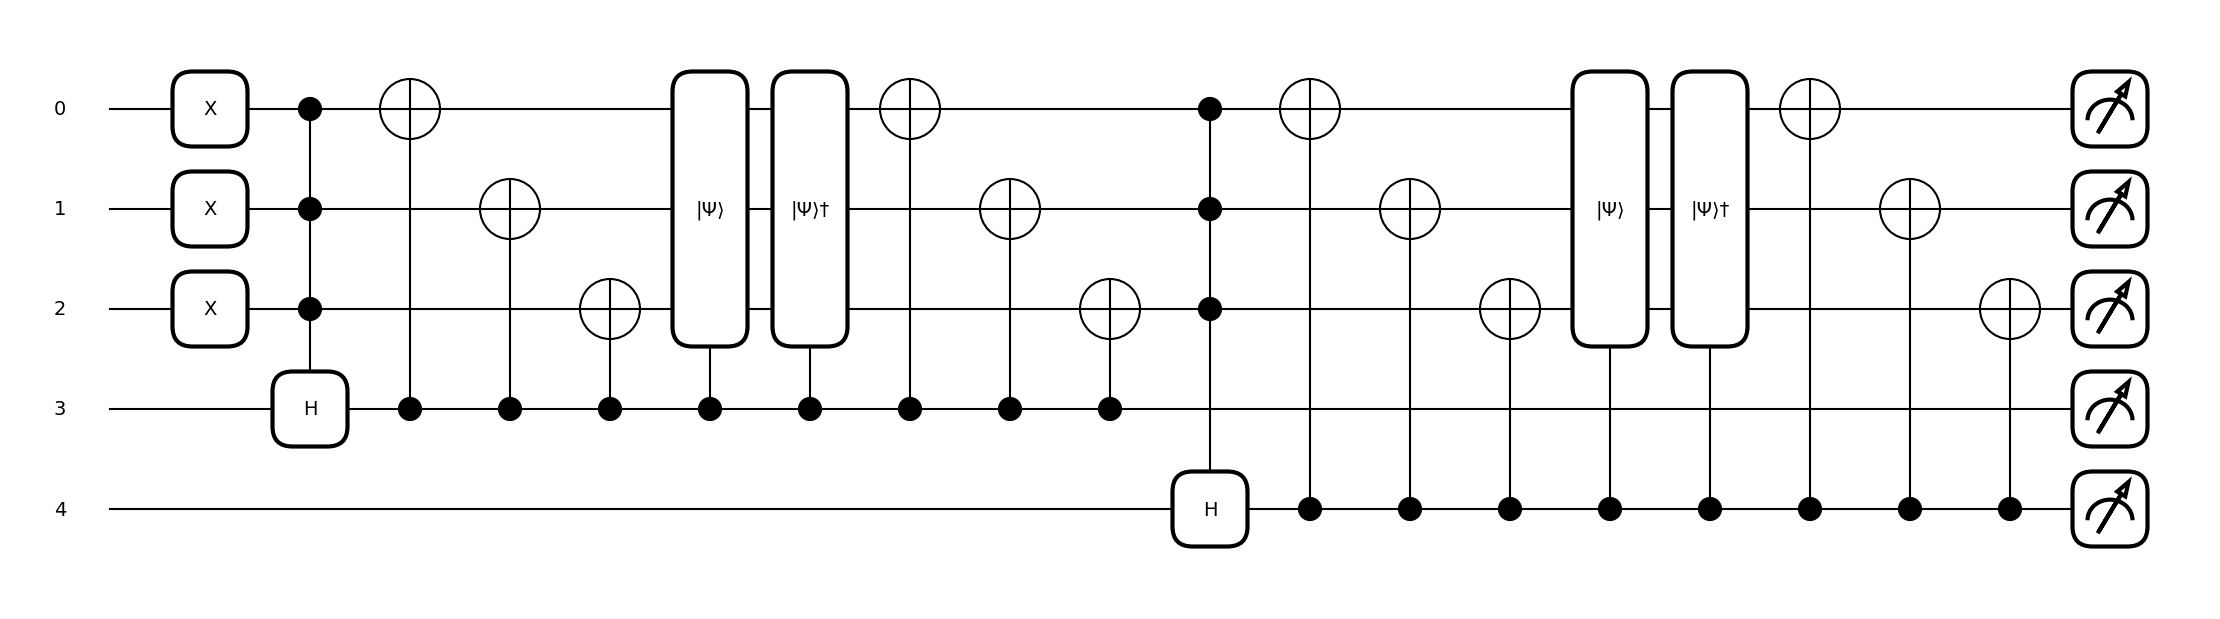

In [175]:
# list Initiallize
x_list = [0.1, -0.2, 0.3, -0.4]
w_list = [0.8, 0.7, -0.9, -0.3]
# x_list = [0.1]
# w_list = [0.8]
b = 0.5
d = 2

test2 = Theorem1(w=w_list, x=x_list, b=b, d=d)
result = test2.theorem1(chk=True)

In [ ]:
k = 0
result = test2.corollary1(k)
print(result)
result = result * (2 ** (d / 2))
if k > 0:
    result = result ** (1 / k)
print(result) # k = 0이면 1, k > 0이면 z

(0.4999999999999999+0j)
(0.9999999999999998+0j)
